# TSP: Clustering + GNN

## Loading Saved Model Example

### Setting up

In [1]:
# # Install torch geometric
# import os

# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-geometric
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

import time

from sklearn.utils import shuffle
from scipy.spatial.distance import pdist, squareform
from sklearn.utils.class_weight import compute_class_weight

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
import torch_geometric

In [3]:
#@title Dataloader definitions
class DotDict(dict):
    """Wrapper around in-built dict class to access members through the dot operation.
    """

    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


class GoogleTSPReader(object):
    """Iterator that reads TSP dataset files and yields mini-batches.

    Format expected as in Vinyals et al., 2015: https://arxiv.org/abs/1506.03134, http://goo.gl/NDcOIG
    """

    def __init__(self, num_nodes, num_neighbors, batch_size, filepath):
        """
        Args:
            num_nodes: Number of nodes in TSP tours
            num_neighbors: Number of neighbors to consider for each node in graph
            batch_size: Batch size
            filepath: Path to dataset file (.txt file)
        """
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.batch_size = batch_size
        self.filepath = filepath
        self.filedata = shuffle(open(filepath, "r").readlines())  # Always shuffle upon reading data
        self.max_iter = (len(self.filedata) // batch_size)

    def __iter__(self):
        for batch in range(self.max_iter):
            start_idx = batch * self.batch_size
            end_idx = (batch + 1) * self.batch_size
            yield self.process_batch(self.filedata[start_idx:end_idx])

    def process_batch(self, lines):
        """Helper function to convert raw lines into a mini-batch as a DotDict.
        """
        batch_edges = []
        batch_edges_values = []
        batch_edges_target = []  # Binary classification targets (0/1)
        batch_nodes = []
        batch_nodes_target = []  # Multi-class classification targets (`num_nodes` classes)
        batch_nodes_coord = []
        batch_tour_nodes = []
        batch_tour_len = []

        for line_num, line in enumerate(lines):
            line = line.split(" ")  # Split into list

            # Compute signal on nodes
            nodes = np.ones(self.num_nodes)  # All 1s for TSP...

            # Convert node coordinates to required format
            nodes_coord = []
            for idx in range(0, 2 * self.num_nodes, 2):
                nodes_coord.append([float(line[idx]), float(line[idx + 1])])

            # Compute distance matrix
            W_val = squareform(pdist(nodes_coord, metric='euclidean'))

            # Compute adjacency matrix
            if self.num_neighbors == -1:
                W = np.ones((self.num_nodes, self.num_nodes))  # Graph is fully connected
            else:
                W = np.zeros((self.num_nodes, self.num_nodes))
                # Determine k-nearest neighbors for each node
                knns = np.argpartition(W_val, kth=self.num_neighbors, axis=-1)[:, self.num_neighbors::-1]
                # Make connections
                for idx in range(self.num_nodes):
                    W[idx][knns[idx]] = 1
            np.fill_diagonal(W, 2)  # Special token for self-connections

            # Convert tour nodes to required format
            # Don't add final connection for tour/cycle
            tour_nodes = [int(node) - 1 for node in line[line.index('output') + 1:-1]][:-1]

            # Compute node and edge representation of tour + tour_len
            tour_len = 0
            nodes_target = np.zeros(self.num_nodes)
            edges_target = np.zeros((self.num_nodes, self.num_nodes))
            for idx in range(len(tour_nodes) - 1):
                i = tour_nodes[idx]
                j = tour_nodes[idx + 1]
                nodes_target[i] = idx  # node targets: ordering of nodes in tour
                edges_target[i][j] = 1
                edges_target[j][i] = 1
                tour_len += W_val[i][j]

            # Add final connection of tour in edge target
            nodes_target[j] = len(tour_nodes) - 1
            edges_target[j][tour_nodes[0]] = 1
            edges_target[tour_nodes[0]][j] = 1
            tour_len += W_val[j][tour_nodes[0]]

            # Concatenate the data
            batch_edges.append(W)
            batch_edges_values.append(W_val)
            batch_edges_target.append(edges_target)
            batch_nodes.append(nodes)
            batch_nodes_target.append(nodes_target)
            batch_nodes_coord.append(nodes_coord)
            batch_tour_nodes.append(tour_nodes)
            batch_tour_len.append(tour_len)

        # From list to tensors as a DotDict
        batch = DotDict()
        batch.edges = np.stack(batch_edges, axis=0)
        batch.edges_values = np.stack(batch_edges_values, axis=0)
        batch.edges_target = np.stack(batch_edges_target, axis=0)
        batch.nodes = np.stack(batch_nodes, axis=0)
        batch.nodes_target = np.stack(batch_nodes_target, axis=0)
        batch.nodes_coord = np.stack(batch_nodes_coord, axis=0)
        batch.tour_nodes = np.stack(batch_tour_nodes, axis=0)
        batch.tour_len = np.stack(batch_tour_len, axis=0)
        return batch

dtypeFloat = torch.cuda.FloatTensor
dtypeLong = torch.cuda.LongTensor

In [4]:
#@title Plotting helper function

def plot_tsp(p, x_coord, W, W_val, W_target, title="default"):
    """
    Helper function to plot TSP tours.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W: Edge adjacency matrix
        W_val: Edge values (distance) matrix
        W_target: One-hot matrix with 1s on groundtruth/predicted edges
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] == 1:
                    pairs.append((r, c))
        return pairs

    G = nx.DiGraph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    adj_pairs = _edges_to_node_pairs(W)
    target_pairs = _edges_to_node_pairs(W_target)
    colors = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=adj_pairs, alpha=0.3, width=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=target_pairs, alpha=1, width=1, edge_color='r')
    p.set_title(title)
    return p

In [5]:
#@title Batch normalization layers
class BatchNormNode(nn.Module):
    """Batch normalization for node features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)

    def forward(self, x):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)

        Returns:
            x_bn: Node features after batch normalization (batch_size, num_nodes, hidden_dim)
        """
        x_trans = x.transpose(1, 2).contiguous()  # Reshape input: (batch_size, hidden_dim, num_nodes)
        x_trans_bn = self.batch_norm(x_trans)
        x_bn = x_trans_bn.transpose(1, 2).contiguous()  # Reshape to original shape
        return x_bn


class BatchNormEdge(nn.Module):
    """Batch normalization for edge features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)

    def forward(self, e):
        """
        Args:
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_bn: Edge features after batch normalization (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_trans = e.transpose(1, 3).contiguous()  # Reshape input: (batch_size, num_nodes, num_nodes, hidden_dim)
        e_trans_bn = self.batch_norm(e_trans)
        e_bn = e_trans_bn.transpose(1, 3).contiguous()  # Reshape to original
        return e_bn

In [6]:
#@title MLP layer
class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)

        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

In [7]:
class NodeFeatures(nn.Module):
    """Convnet features for nodes.

    Using `sum` aggregation:
        x_i = U*x_i +  sum_j [ gate_ij * (V*x_j) ]

    Using `mean` aggregation:
        x_i = U*x_i + ( sum_j [ gate_ij * (V*x_j) ] / sum_j [ gate_ij] )
    """

    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__()
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, edge_gate):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            edge_gate: Edge gate values (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
        """
        Ux = self.U(x)  # B x V x H
        Vx = self.V(x)  # B x V x H
        Vx = Vx.unsqueeze(1)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        gateVx = edge_gate * Vx  # B x V x V x H
        if self.aggregation=="mean":
            x_new = Ux + torch.sum(gateVx, dim=2) / (1e-20 + torch.sum(edge_gate, dim=2))  # B x V x H
        elif self.aggregation=="sum":
            x_new = Ux + torch.sum(gateVx, dim=2)  # B x V x H
        return x_new


class EdgeFeatures(nn.Module):
    """Convnet features for edges.

    e_ij = U*e_ij + V*(x_i + x_j)
    """

    def __init__(self, hidden_dim):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        Ue = self.U(e)
        Vx = self.V(x)
        Wx = Vx.unsqueeze(1)  # Extend Vx from "B x V x H" to "B x V x 1 x H"
        Vx = Vx.unsqueeze(2)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        e_new = Ue + Vx + Wx
        return e_new

In [8]:
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection.
    """

    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_in = e
        x_in = x
        # Edge convolution
        e_tmp = self.edge_feat(x_in, e_in)  # B x V x V x H
        # Compute edge gates
        edge_gate = torch.sigmoid(e_tmp)
        # Node convolution
        x_tmp = self.node_feat(x_in, edge_gate)
        # Batch normalization
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        # ReLU Activation
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        # Residual connection
        x_new = x_in + x
        e_new = e_in + e
        return x_new, e_new

In [9]:
from torch_geometric.nn import TransformerConv

class ResidualGatedGCNModel(nn.Module):
    """Residual Gated GCN Model for outputting predictions as edge adjacency matrices.
    """

    def __init__(self, config, dtypeFloat, dtypeLong):
        super(ResidualGatedGCNModel, self).__init__()
        self.dtypeFloat = dtypeFloat
        self.dtypeLong = dtypeLong
        # Define net parameters
        self.num_nodes = config['num_nodes']
        self.node_dim = config['node_dim']
        self.voc_nodes_in = config['voc_nodes_in']
        self.voc_nodes_out = config['num_nodes']
        self.voc_edges_in = config['voc_edges_in']
        self.voc_edges_out = config['voc_edges_out']
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.mlp_layers = config['mlp_layers']
        self.aggregation = config['aggregation']
        # Node and edge embedding layers/lookups

        # We are using TransformerConv layer from torch geometric library!
        self.nodes_coord_embedding = TransformerConv(self.node_dim, self.hidden_dim)

        self.edges_values_embedding = nn.Linear(1, self.hidden_dim//2, bias=False)
        self.edges_embedding = nn.Embedding(self.voc_edges_in, self.hidden_dim//2)
        # Define GCN Layers
        gcn_layers = []
        for layer in range(self.num_layers):
            gcn_layers.append(ResidualGatedGCNLayer(self.hidden_dim, self.aggregation))
        self.gcn_layers = nn.ModuleList(gcn_layers)
        # Define MLP classifiers
        self.mlp_edges = MLP(self.hidden_dim, self.voc_edges_out, self.mlp_layers)

    def loss_edges(self, y_pred_edges, y_edges, edge_cw):
        """
        Loss function for edge predictions.

        Args:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss

        Returns:
            loss_edges: Value of loss function

        """
        # Edge loss
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        y = y.permute(0, 3, 1, 2)  # B x voc_edges x V x V
        loss_edges = nn.NLLLoss(edge_cw)
        loss = loss_edges(y.contiguous(), y_edges)
        return loss

    def forward(self, x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw):
        """
        Args:
            x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
            x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
            x_nodes: Input nodes (batch_size, num_nodes)
            x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss
            # y_nodes: Targets for nodes (batch_size, num_nodes, num_nodes)
            # node_cw: Class weights for nodes loss

        Returns:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            # y_pred_nodes: Predictions for nodes (batch_size, num_nodes)
            loss: Value of loss function
        """
        # Node and edge embedding
        edge_index = torch.squeeze(x_edges).nonzero().t().contiguous()
        x = self.nodes_coord_embedding(torch.squeeze(x_nodes_coord), edge_index)
        x = torch.unsqueeze(x, 0)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(3))  # B x V x V x H
        e_tags = self.edges_embedding(x_edges)  # B x V x V x H
        e = torch.cat((e_vals, e_tags), dim=3)
        # GCN layers
        for layer in range(self.num_layers):
            x, e = self.gcn_layers[layer](x, e)  # B x V x H, B x V x V x H
        # MLP classifier
        y_pred_edges = self.mlp_edges(e)  # B x V x V x voc_edges_out

        # Compute loss
        edge_cw = torch.Tensor(edge_cw).type(self.dtypeFloat)  # Convert to tensors
        loss = self.loss_edges(y_pred_edges.cuda(), y_edges.cuda(), edge_cw)

        return y_pred_edges, loss

In [10]:
#@title Hyperparameters

num_nodes = 30 #@param # Could also be 10, 20, or 30!
num_neighbors = -1 # Could increase it!
train_filepath = f"./tsp-data/tsp{num_nodes}_train_concorde.txt"
hidden_dim = 100 #@param
num_layers = 5 #@param
mlp_layers = 2 #@param
learning_rate = 0.01 #@param
max_epochs = 30 #@param
batches_per_epoch = 10000

variables = {'train_filepath': f'./tsp-data/tsp{num_nodes}_train_concorde.txt',
             'val_filepath': f'./tsp-data/tsp{num_nodes}_val_concorde.txt',
             'test_filepath': f'./tsp-data/tsp{num_nodes}_test_concorde.txt',
             'num_nodes': num_nodes,
             'num_neighbors': num_neighbors,
             'node_dim': 2 ,
             'voc_nodes_in': 2,
             'voc_nodes_out': 2,
             'voc_edges_in': 3,
             'voc_edges_out': 2,
             'hidden_dim': hidden_dim,
             'num_layers': num_layers,
             'mlp_layers': mlp_layers,
             'aggregation': 'mean',
             'max_epochs': max_epochs,
             'val_every': 5,
             'test_every': 5,
             'batches_per_epoch': batches_per_epoch,
             'accumulation_steps': 1,
             'learning_rate': learning_rate,
             'decay_rate': 1.01
             }

In [11]:
#@title Plotting helper functions

def plot_loss_curve(train_loss, val_loss, test_loss, config):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the losses on the axis
    val_every = config["val_every"]
    test_every = config["test_every"]
    test_every = [15]
    ax.plot(train_loss, color='green', label='Train Loss')
    ax.plot([i * val_every for i in range(len(val_loss))], val_loss, color='orange', label='Val Loss')
    ax.plot([i * test_every for i in range(len(test_loss))], test_loss, color='purple', label='Test Loss')

    # Add axis labels and title
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss Curve")
    ax.legend()

    # Show the plot
    plt.figure(figsize=(15,10))
    plt.show()

def plot_tsp_heatmap(p, x_coord, W_val, W_pred, title="default"):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W_val: Edge values (distance) matrix
        W_pred: Edge predictions matrix
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        edge_preds = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] > 0.25:
                    pairs.append((r, c))
                    edge_preds.append(W[r][c])
        return pairs, edge_preds

    G = nx.Graph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    node_pairs, edge_color = _edges_to_node_pairs(W_pred)
    node_color = ['g'] + ['b'] * (len(x_coord) - 1)  # Green for 0th node, blue for others
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=0.75)
    p.set_title(title)
    return p


def plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_pred_edges, num_plots=3):
    """
    Plots groundtruth TSP tour vs. predicted tours (with beamsearch).

    Args:
        x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
        x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        y_edges: Groundtruth labels for edges (batch_size, num_nodes, num_nodes)
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        num_plots: Number of figures to plot

    """

    y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
    y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
    for f_idx, idx in enumerate(np.random.choice(len(y), num_plots, replace=False)):
        f = plt.figure(f_idx, figsize=(15, 5))
        x_coord = x_nodes_coord[idx].cpu().numpy()
        W = x_edges[idx].cpu().numpy()
        W_val = x_edges_values[idx].cpu().numpy()
        W_target = y_edges[idx].cpu().numpy()
        W_sol_bins = y_bins[idx].cpu().numpy()
        W_sol_probs = y_probs[idx].cpu().numpy()
        plt1 = f.add_subplot(131)
        plot_tsp(plt1, x_coord.squeeze(), W.squeeze(), W_val.squeeze(), W_target.squeeze(), 'Groundtruth')
        plt2 = f.add_subplot(132)
        plot_tsp_heatmap(plt2, x_coord.squeeze(), W_val.squeeze(), W_sol_probs.squeeze(), 'Prediction Heatmap')
        plt.show()

### Load Model

Model Specification

```Python
num_nodes = 30 #@param # Could also be 10, 20, or 30!
num_neighbors = -1 # Could increase it!
train_filepath = f"./tsp-data/tsp{num_nodes}_train_concorde.txt"
hidden_dim = 300 #@param
num_layers = 5 #@param
mlp_layers = 2 #@param
learning_rate = 0.01 #@param
max_epochs = 30 #@param
batches_per_epoch = 10000

variables = {'train_filepath': f'./tsp-data/tsp{num_nodes}_train_concorde.txt',
             'val_filepath': f'./tsp-data/tsp{num_nodes}_val_concorde.txt',
             'test_filepath': f'./tsp-data/tsp{num_nodes}_test_concorde.txt',
             'num_nodes': num_nodes,
             'num_neighbors': num_neighbors,
             'node_dim': 2 ,
             'voc_nodes_in': 2,
             'voc_nodes_out': 2,
             'voc_edges_in': 3,
             'voc_edges_out': 2,
             'hidden_dim': hidden_dim,
             'num_layers': num_layers,
             'mlp_layers': mlp_layers,
             'aggregation': 'mean',
             'max_epochs': max_epochs,
             'val_every': 5,
             'test_every': 5,
             'batches_per_epoch': batches_per_epoch,
             'accumulation_steps': 1,
             'learning_rate': learning_rate,
             'decay_rate': 1.01
             }
```

In [12]:
net = torch.load("model2.pth")

/tmp/ipykernel_11262/3910326508.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("model2.pth")


### Testing

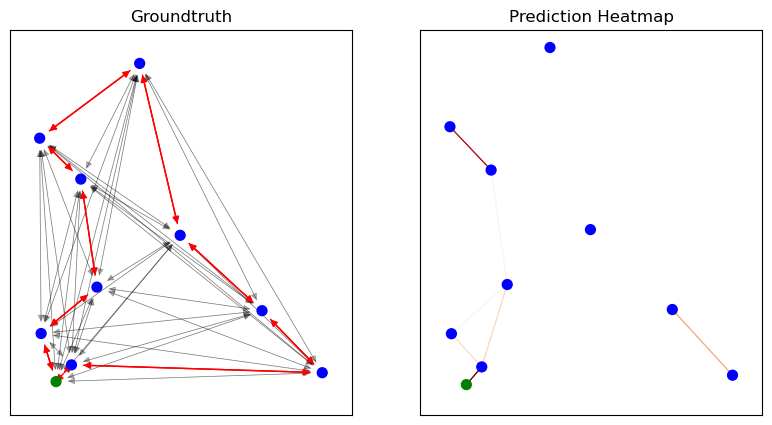

In [13]:
# Set evaluation mode
net.eval()

num_samples = 1
num_nodes = 10
num_neighbors = -1
test_filepath = f'./tsp-data/tsp{num_nodes}_test_concorde.txt'
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, 1, test_filepath))


x_edges = []
x_edges_values = []
x_nodes = []
x_nodes_coord = []
y_edges = []
y_nodes = []
y_preds = []

with torch.no_grad():
    for i in range(num_samples):
        sample = next(dataset)
        # Convert batch to torch Variables
        x_edges.append(Variable(torch.LongTensor(sample.edges).type(dtypeLong), requires_grad=False))
        x_edges_values.append(Variable(torch.FloatTensor(sample.edges_values).type(dtypeFloat), requires_grad=False))
        x_nodes.append(Variable(torch.LongTensor(sample.nodes).type(dtypeLong), requires_grad=False))
        x_nodes_coord.append(Variable(torch.FloatTensor(sample.nodes_coord).type(dtypeFloat), requires_grad=False))
        y_edges.append(Variable(torch.LongTensor(sample.edges_target).type(dtypeLong), requires_grad=False))
        y_nodes.append(Variable(torch.LongTensor(sample.nodes_target).type(dtypeLong), requires_grad=False))

        # Compute class weights
        edge_labels = (y_edges[-1].cpu().numpy().flatten())
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        # Forward pass
        y_pred, loss = net.forward(x_edges[-1], x_edges_values[-1], x_nodes[-1], x_nodes_coord[-1], y_edges[-1], edge_cw)
        y_preds.append(y_pred)

y_preds = torch.squeeze(torch.stack(y_preds))
if y_preds.dim() == 3:
    y_preds = y_preds.unsqueeze(0)

# Plot prediction visualizations
plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=num_samples)

In [14]:
print(y_preds.shape)
print(y_preds)

torch.Size([1, 10, 10, 2])
tensor([[[[ 4.6251e+03, -3.9887e+03],
          [ 2.6262e+00, -2.6869e+00],
          [ 3.8862e+02, -3.6246e+02],
          [ 7.2618e-01, -1.5405e+00],
          [ 2.7784e+01, -2.3268e+01],
          [ 8.7613e+00, -9.1111e+00],
          [ 4.2918e+03, -3.9431e+03],
          [ 4.0442e+02, -3.7488e+02],
          [ 1.0702e+03, -1.0087e+03],
          [-3.0156e+00,  7.1723e-01]],

         [[ 2.6262e+00, -2.6869e+00],
          [ 5.0576e+03, -4.3869e+03],
          [ 8.1716e-01, -1.5954e+00],
          [-2.2909e-01, -9.6410e-01],
          [ 2.6262e+00, -2.6869e+00],
          [ 2.6262e+00, -2.6869e+00],
          [ 1.5255e+01, -1.3683e+01],
          [-2.6287e-01, -9.4371e-01],
          [ 2.6262e+00, -2.6869e+00],
          [-4.9707e-01, -8.0240e-01]],

         [[ 3.8862e+02, -3.6246e+02],
          [ 8.1716e-01, -1.5954e+00],
          [ 5.2591e+03, -4.5881e+03],
          [ 2.3838e+02, -2.1123e+02],
          [ 1.8971e+00, -2.2470e+00],
          [ 2.6262e

### Beam Search

In [15]:
#@title Beam search class
class Beamsearch(object):
    """Class for managing internals of beamsearch procedure.

    References:
        General: https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam.py
        For TSP: https://github.com/alexnowakvila/QAP_pt/blob/master/src/tsp/beam_search.py
    """

    def __init__(self, beam_size, batch_size, num_nodes,
                 dtypeFloat=torch.cuda.FloatTensor, dtypeLong=torch.cuda.LongTensor,
                 probs_type='raw', random_start=False):
        """
        Args:
            beam_size: Beam size
            batch_size: Batch size
            num_nodes: Number of nodes in TSP tours
            dtypeFloat: Float data type (for GPU/CPU compatibility)
            dtypeLong: Long data type (for GPU/CPU compatibility)
            probs_type: Type of probability values being handled by beamsearch (either 'raw'/'logits'/'argmax'(TODO))
            random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch
        """
        # Beamsearch parameters
        self.batch_size = batch_size
        self.beam_size = beam_size
        self.num_nodes = num_nodes
        self.probs_type = probs_type
        # Set data types
        self.dtypeFloat = dtypeFloat
        self.dtypeLong = dtypeLong
        # Set beamsearch starting nodes
        self.start_nodes = torch.zeros(batch_size, beam_size).type(self.dtypeLong)
        if random_start == True:
            # Random starting nodes
            self.start_nodes = torch.randint(0, num_nodes, (batch_size, beam_size)).type(self.dtypeLong)
        # Mask for constructing valid hypothesis
        self.mask = torch.ones(batch_size, beam_size, num_nodes).type(self.dtypeFloat)
        self.update_mask(self.start_nodes)  # Mask the starting node of the beam search
        # Score for each translation on the beam
        self.scores = torch.zeros(batch_size, beam_size).type(self.dtypeFloat)
        self.all_scores = []
        # Backpointers at each time-step
        self.prev_Ks = []
        # Outputs at each time-step
        self.next_nodes = [self.start_nodes]

    def get_current_state(self):
        """Get the output of the beam at the current timestep.
        """
        current_state = (self.next_nodes[-1].unsqueeze(2)
                         .expand(self.batch_size, self.beam_size, self.num_nodes))
        return current_state

    def get_current_origin(self):
        """Get the backpointers for the current timestep.
        """
        return self.prev_Ks[-1]

    def advance(self, trans_probs):
        """Advances the beam based on transition probabilities.

        Args:
            trans_probs: Probabilities of advancing from the previous step (batch_size, beam_size, num_nodes)
        """
        # Compound the previous scores (summing logits == multiplying probabilities)
        if len(self.prev_Ks) > 0:
            if self.probs_type == 'raw':
                beam_lk = trans_probs * self.scores.unsqueeze(2).expand_as(trans_probs)
            elif self.probs_type == 'logits':
                beam_lk = trans_probs + self.scores.unsqueeze(2).expand_as(trans_probs)
        else:
            beam_lk = trans_probs
            # Only use the starting nodes from the beam
            if self.probs_type == 'raw':
                beam_lk[:, 1:] = torch.zeros(beam_lk[:, 1:].size()).type(self.dtypeFloat)
            elif self.probs_type == 'logits':
                beam_lk[:, 1:] = -1e20 * torch.ones(beam_lk[:, 1:].size()).type(self.dtypeFloat)
        # Multiply by mask
        beam_lk = beam_lk * self.mask
        beam_lk = beam_lk.view(self.batch_size, -1)  # (batch_size, beam_size * num_nodes)
        # Get top k scores and indexes (k = beam_size)
        bestScores, bestScoresId = beam_lk.topk(self.beam_size, 1, True, True)
        # Update scores
        self.scores = bestScores
        # Update backpointers
        prev_k = bestScoresId / self.num_nodes
        self.prev_Ks.append(prev_k)
        # Update outputs
        new_nodes = bestScoresId - prev_k * self.num_nodes
        self.next_nodes.append(new_nodes)
        # Re-index mask
        perm_mask = prev_k.unsqueeze(2).expand_as(self.mask).type(self.dtypeLong)  # (batch_size, beam_size, num_nodes)
        self.mask = self.mask.gather(1, perm_mask)
        # Mask newly added nodes
        self.update_mask(new_nodes)

    def update_mask(self, new_nodes):
        """Sets new_nodes to zero in mask.
        """
        arr = (torch.arange(0, self.num_nodes).unsqueeze(0).unsqueeze(1)
               .expand_as(self.mask).type(self.dtypeLong))
        new_nodes = new_nodes.unsqueeze(2).expand_as(self.mask)
        update_mask = 1 - torch.eq(arr, new_nodes).type(self.dtypeFloat)
        self.mask = self.mask * update_mask
        if self.probs_type == 'logits':
            # Convert 0s in mask to inf
            self.mask[self.mask == 0] = 1e20

    def sort_best(self):
        """Sort the beam.
        """
        return torch.sort(self.scores, 0, True)

    def get_best(self):
        """Get the score and index of the best hypothesis in the beam.
        """
        scores, ids = self.sort_best()
        return scores[1], ids[1]

    def get_hypothesis(self, k):
        """Walk back to construct the full hypothesis.

        Args:
            k: Position in the beam to construct (usually 0s for most probable hypothesis)
        """
        assert self.num_nodes == len(self.prev_Ks) + 1
        hyp = -1 * torch.ones(self.batch_size, self.num_nodes).type(self.dtypeLong)
        for j in range(len(self.prev_Ks) - 1, -2, -1):
            hyp[:, j + 1] = self.next_nodes[j + 1].gather(1, k).view(1, self.batch_size)
            k = self.prev_Ks[j].type(self.dtypeLong).gather(1, k)
        return hyp

In [16]:
#@title Beam search helper functions
def W_to_tour_len(W, W_values):
    """Helper function to calculate tour length from edge adjacency matrix.
    """
    tour_len = 0
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if W[i][j] == 1:
                tour_len += W_values[i][j]
    tour_len /= 2  # Divide by 2 because adjacency matrices are symmetric
    return tour_len


def tour_nodes_to_W(nodes):
    """Helper function to convert ordered list of tour nodes to edge adjacency matrix.
    """
    W = np.zeros((len(nodes), len(nodes)))
    for idx in range(len(nodes) - 1):
        i = int(nodes[idx])
        j = int(nodes[idx + 1])
        W[i][j] = 1
        W[j][i] = 1
    # Add final connection of tour in edge target
    W[j][int(nodes[0])] = 1
    W[int(nodes[0])][j] = 1
    return W

def tour_nodes_to_tour_len(nodes, W_values):
    """Helper function to calculate tour length from ordered list of tour nodes.
    """
    tour_len = 0
    for idx in range(len(nodes) - 1):
        i = nodes[idx]
        j = nodes[idx + 1]
        tour_len += W_values[i][j]
    # Add final connection of tour in edge target
    tour_len += W_values[j][nodes[0]]
    return tour_len


def is_valid_tour(nodes, num_nodes):
    """Sanity check: tour visits all nodes given.
    """
    return sorted(nodes) == [i for i in range(num_nodes)]


def mean_tour_len_edges(x_edges_values, y_pred_edges):
    """
    Computes mean tour length for given batch prediction as edge adjacency matrices (for PyTorch tensors).

    Args:
        x_edges_values: Edge values (distance) matrix (batch_size, num_nodes, num_nodes)
        y_pred_edges: Edge predictions (batch_size, num_nodes, num_nodes, voc_edges)

    Returns:
        mean_tour_len: Mean tour length over batch
    """
    y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y = y.argmax(dim=3)  # B x V x V
    # Divide by 2 because edges_values is symmetric
    tour_lens = (y.float() * x_edges_values.float()).sum(dim=1).sum(dim=1) / 2
    mean_tour_len = tour_lens.sum().to(dtype=torch.float).item() / tour_lens.numel()
    return mean_tour_len


def mean_tour_len_nodes(x_edges_values, bs_nodes):
    """
    Computes mean tour length for given batch prediction as node ordering after beamsearch (for Pytorch tensors).

    Args:
        x_edges_values: Edge values (distance) matrix (batch_size, num_nodes, num_nodes)
        bs_nodes: Node orderings (batch_size, num_nodes)

    Returns:
        mean_tour_len: Mean tour length over batch
    """
    y = bs_nodes.cpu().numpy()
    W_val = x_edges_values.cpu().numpy()
    running_tour_len = 0
    for batch_idx in range(y.shape[0]):
        for y_idx in range(y[batch_idx].shape[0] - 1):
            i = y[batch_idx][y_idx]
            j = y[batch_idx][y_idx + 1]
            running_tour_len += W_val[batch_idx][i][j]
        running_tour_len += W_val[batch_idx][j][0]  # Add final connection to tour/cycle
    return running_tour_len / y.shape[0]


def beamsearch_tour_nodes(y_pred_edges, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='raw', random_start=False):
    """
    Performs beamsearch procedure on edge prediction matrices and returns possible TSP tours.

    Args:
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        beam_size: Beam size
        batch_size: Batch size
        num_nodes: Number of nodes in TSP tours
        dtypeFloat: Float data type (for GPU/CPU compatibility)
        dtypeLong: Long data type (for GPU/CPU compatibility)
        random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch

    Returns: TSP tours in terms of node ordering (batch_size, num_nodes)

    """

    print("y_pred_edges shape:", y_pred_edges.shape)
    print("y_pred_edges values:", y_pred_edges)

    if probs_type == 'raw':
        # Compute softmax over edge prediction matrix
        y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        print("Softmax output:", y)
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
    elif probs_type == 'logits':
        # Compute logits over edge prediction matrix
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
        y[y == 0] = -1e-20  # Set 0s (i.e. log(1)s) to very small negative number
    # Perform beamsearch
    beamsearch = Beamsearch(beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type, random_start)
    print("Start nodes:", beamsearch.start_nodes)
    print("Mask initialized:", beamsearch.mask)
    trans_probs = y.gather(1, beamsearch.get_current_state())
    print("Initial transition probs:", trans_probs)
    for step in range(num_nodes - 1):
        beamsearch.advance(trans_probs)
        print("Scores after advancing:", beamsearch.scores)
        print("Mask after advancing:", beamsearch.mask)
        trans_probs = y.gather(1, beamsearch.get_current_state().type(dtypeLong))
    # Find TSP tour with highest probability among beam_size candidates
    ends = torch.zeros(batch_size, 1).type(dtypeLong)
    hyp = beamsearch.get_hypothesis(ends)
    print("Final hypothesis (best path):", hyp)
    return hyp


def beamsearch_tour_nodes_shortest(y_pred_edges, x_edges_values, beam_size, batch_size, num_nodes,
                                   dtypeFloat, dtypeLong, probs_type='raw', random_start=False):
    """
    Performs beamsearch procedure on edge prediction matrices and returns possible TSP tours.

    Final predicted tour is the one with the shortest tour length.
    (Standard beamsearch returns the one with the highest probability and does not take length into account.)

    Args:
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        beam_size: Beam size
        batch_size: Batch size
        num_nodes: Number of nodes in TSP tours
        dtypeFloat: Float data type (for GPU/CPU compatibility)
        dtypeLong: Long data type (for GPU/CPU compatibility)
        probs_type: Type of probability values being handled by beamsearch (either 'raw'/'logits'/'argmax'(TODO))
        random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch

    Returns:
        shortest_tours: TSP tours in terms of node ordering (batch_size, num_nodes)

    """
    if probs_type == 'raw':
        # Compute softmax over edge prediction matrix
        y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
    elif probs_type == 'logits':
        # Compute logits over edge prediction matrix
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        # Consider the second dimension only
        y = y[:, :, :, 1]  # B x V x V
        y[y == 0] = -1e-20  # Set 0s (i.e. log(1)s) to very small negative number
    # Perform beamsearch
    beamsearch = Beamsearch(beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type, random_start)
    trans_probs = y.gather(1, beamsearch.get_current_state())
    for step in range(num_nodes - 1):
        beamsearch.advance(trans_probs)
        trans_probs = y.gather(1, beamsearch.get_current_state().type(dtypeLong))
    # Initially assign shortest_tours as most probable tours i.e. standard beamsearch
    ends = torch.zeros(batch_size, 1).type(dtypeLong)
    shortest_tours = beamsearch.get_hypothesis(ends)
    # Compute current tour lengths
    shortest_lens = [1e6] * len(shortest_tours)
    for idx in range(len(shortest_tours)):
        shortest_lens[idx] = tour_nodes_to_tour_len(shortest_tours[idx].cpu().numpy(),
                                                    x_edges_values[idx].cpu().numpy())
    # Iterate over all positions in beam (except position 0 --> highest probability)
    for pos in range(1, beam_size):
        ends = pos * torch.ones(batch_size, 1).type(dtypeLong)  # New positions
        hyp_tours = beamsearch.get_hypothesis(ends)
        for idx in range(len(hyp_tours)):
            hyp_nodes = hyp_tours[idx].cpu().numpy()
            hyp_len = tour_nodes_to_tour_len(hyp_nodes, x_edges_values[idx].cpu().numpy())
            # Replace tour in shortest_tours if new length is shorter than current best
            if hyp_len < shortest_lens[idx] and is_valid_tour(hyp_nodes, num_nodes).all():
                shortest_tours[idx] = hyp_tours[idx]
                shortest_lens[idx] = hyp_len
    return shortest_tours

In [17]:
# Assuming y_preds contains edge probability predictions from your model

# Beam Search Configuration
beam_size = 10
batch_size = num_samples

# Use beam search to get the optimal tour based on shortest length
tours = beamsearch_tour_nodes(
    y_preds,
    beam_size,
    batch_size,
    num_nodes,
    dtypeFloat=torch.cuda.FloatTensor,
    dtypeLong=torch.cuda.LongTensor
)

print(tours)

# Convert tours to edge adjacency matrices or calculate tour lengths as needed
# for idx, tour_nodes in enumerate(tours):
#     # Convert node sequence to adjacency matrix for visualization or further use
#     W = tour_nodes_to_W(tour_nodes.cpu().numpy())
#     tour_len = tour_nodes_to_tour_len(tour_nodes.cpu().numpy(), x_edges_values[idx].cpu().numpy())
#     print(f"Sample {idx+1} - Tour length: {tour_len}")


y_pred_edges shape: torch.Size([1, 10, 10, 2])
y_pred_edges values: tensor([[[[ 4.6251e+03, -3.9887e+03],
          [ 2.6262e+00, -2.6869e+00],
          [ 3.8862e+02, -3.6246e+02],
          [ 7.2618e-01, -1.5405e+00],
          [ 2.7784e+01, -2.3268e+01],
          [ 8.7613e+00, -9.1111e+00],
          [ 4.2918e+03, -3.9431e+03],
          [ 4.0442e+02, -3.7488e+02],
          [ 1.0702e+03, -1.0087e+03],
          [-3.0156e+00,  7.1723e-01]],

         [[ 2.6262e+00, -2.6869e+00],
          [ 5.0576e+03, -4.3869e+03],
          [ 8.1716e-01, -1.5954e+00],
          [-2.2909e-01, -9.6410e-01],
          [ 2.6262e+00, -2.6869e+00],
          [ 2.6262e+00, -2.6869e+00],
          [ 1.5255e+01, -1.3683e+01],
          [-2.6287e-01, -9.4371e-01],
          [ 2.6262e+00, -2.6869e+00],
          [-4.9707e-01, -8.0240e-01]],

         [[ 3.8862e+02, -3.6246e+02],
          [ 8.1716e-01, -1.5954e+00],
          [ 5.2591e+03, -4.5881e+03],
          [ 2.3838e+02, -2.1123e+02],
          [ 1.89

## Apply TSP with Clustering!

### A HUGE Input

In [18]:
num_vertices = 200
num_clusters = 'default'

### Generate Clusters

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time

In [20]:
def set_parameters(num_vertices, num_clusters):
    data_path = f'./tsp-data/tsp{num_vertices}_test_concorde.txt'
    if not isinstance(num_clusters, int):
        num_clusters = round((num_vertices * 0.5) ** 0.5)
    return data_path, num_clusters

data_path, num_clusters = set_parameters(num_vertices, num_clusters)

In [21]:
class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __str__(self):
        return f"({self.x}, {self.y})"
    
    def __repr__(self):
        return f"({self.x}, {self.y})"
    
    def points(self):
        return [self.x, self.y]
    
    def __lt__(self, other):
        return self.x < other.x if self.x != other.x else self.y < other.y
    
    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

In [22]:
def read_data(data_path, num_repeat, shuffle=True):
    with open(data_path, 'r') as file:
        data = [line.strip() for line in file.readlines()]

        if shuffle:
            random.shuffle(data)
        
        test_cases, optimums = [], []

        for i in range(num_repeat):
            line = data[i].split()
            line, answer = line[:line.index('output')], line[line.index('output')+1:]
            test_case = []
            for j in range(0, len(line), 2):
                test_case.append(Vertex(float(line[j]), float(line[j+1])))
            test_cases.append(test_case)
        
            optimum = []
            for ind in answer:
                ind = int(ind) - 1
                optimum.append(test_case[ind])
            optimums.append(optimum)

        return test_cases, optimums

test_cases, optimums = read_data(data_path, 1)

In [23]:
def assign_clusters(vertices, selected_vertices):
    assignments = {}
    for v in vertices:
        closest_vertex = min(selected_vertices, key=lambda sv: v.distance_to(sv))
        assignments[v] = closest_vertex
    return assignments

def greedy(vertices, k):
    selected = []
    pick = random_pick(vertices)
    selected.append(pick)
    while len(selected) < k:
        furthest_vertex = max_distance_vertex(vertices, selected)
        vertices.remove(furthest_vertex)
        selected.append(furthest_vertex)
    return selected

def random_pick(vertices):
    pick = random.sample(sorted(vertices), 1)[0]
    vertices.remove(pick)
    return pick

def max_distance_vertex(vertices, picked):
    max_distance = -np.inf
    furthest_vertex = None
    for v in vertices:
        min_distance = min(v.distance_to(p) for p in picked)
        if min_distance > max_distance:
            max_distance = min_distance
            furthest_vertex = v
    return furthest_vertex

def random_vertex(min_value, max_value):
    return Vertex(random.randint(min_value, max_value), random.randint(min_value, max_value))

In [24]:
def plot_clusters(vertices, cluster_assignments, selected_vertices):
    # Assign unique colors for each cluster
    colors = plt.colormaps['tab10' if len(selected_vertices) <= 10 else 'tab20']

    for idx, cluster_id in enumerate(selected_vertices):
        # Get vertices belonging to the current cluster
        cluster_points = [v for v in vertices if cluster_assignments[v] == cluster_id]
        xs = [v.x for v in cluster_points]
        ys = [v.y for v in cluster_points]
        
        # Plot cluster points
        plt.scatter(xs, ys, label=f"Cluster {cluster_id}", color=colors(idx))

        # Plot the cluster center with the same color but a different marker (e.g., square)
        plt.scatter(cluster_id.x, cluster_id.y, color=colors(idx), marker='s', edgecolor='black', s=100)

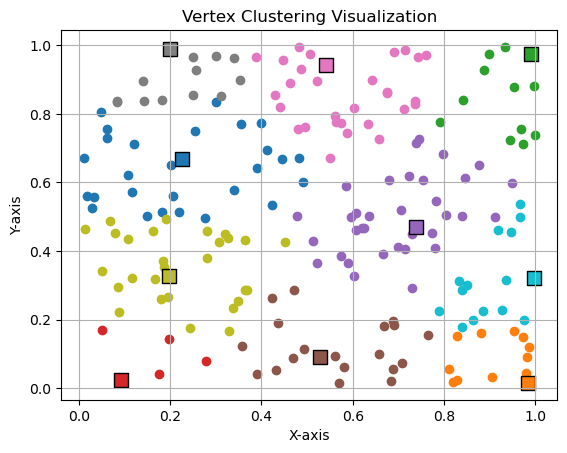

In [25]:
def run_clustering(vertices, num_clusters, show_plot):
    selected_vertices = greedy(vertices, num_clusters)

    # Assign all vertices to the nearest selected vertex
    cluster_assignments = assign_clusters(vertices, selected_vertices)

    if show_plot:
    # Plot clusters
        plot_clusters(vertices, cluster_assignments, selected_vertices)

        plt.title("Vertex Clustering Visualization")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.grid()
        plt.show()

    # Initialize a new dictionary to hold the result
    result_dict = {}

    # Iterate through the original dictionary items
    for key, value in cluster_assignments.items():
        if value not in result_dict:
            result_dict[value] = []  # Create a new list for new keys
        result_dict[value].append(key)  # Append the current key to the list
    
    return vertices, cluster_assignments, selected_vertices

vertices, cluster_assignments, selected_vertices = run_clustering(test_cases[0], num_clusters, True)

### Format Clusters

### Run TSPs Using GNN

### Combine Results